In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
no_imp = ['18rxpu46', '3s15ej23', '1ah30kvf', '1b4sznil', '271qmdv6']
imp = ['28dw1onl', '1o0oz2zl', '19g28guz', '1s11cvnu', '2swvq8ku']

### Download Data

In [3]:
# import wandb
# api = wandb.Api(timeout=9999)

# def get_run(run_id):
#     return api.run("miladink/riemannian_diffusion/"+run_id)

In [4]:
# run_data = {}

In [5]:
# for run_id in no_imp+imp:
#     run = get_run(run_id)
#     data = list(run.scan_history())
#     run_data[run_id] = data
#     print('hey! nice! another one!')

### Write Data to Disk

In [6]:
import json

In [7]:
# for run_id, data in run_data.items():
#     with open('./experiments_data/'+run_id+'.json', 'w') as f:
#         json.dump(data, f)

### Generate Plots

In [8]:
run_data = {}
for run_id in no_imp+imp:
    with open('./experiments_data/'+run_id+'.json', 'r') as f:
        data = json.load(f)
    run_data[run_id] = data

In [9]:
def extract_losses_steps(data):
    losses = []
    steps = []
    for row in data:
        if 'loss' in row:
            losses.append(row['loss'])
            steps.append(row['_step'])
    return steps, losses
            
steps, losses = extract_losses_steps(run_data[no_imp[0]])

In [13]:
# using the following implementation for calculating standard deviation
#https://stats.stackexchange.com/questions/111851/standard-deviation-of-an-exponentially-weighted-mean

In [10]:
def get_em(losses):
    ema = 0
    emstd = 0
    emas = [0.0]
    emstds = []

    beta1 = 0.999
    beta2 = 0.999
    b1p = 1.0
    b2p = 1.0

    for loss in losses:

        b1p *= beta1
        b2p *= beta2

        ema = beta1 * ema + (1-beta1) * loss
        emstd = beta2 * emstd + (1-beta2) * (loss-emas[-1])**2

        # store values
        emas.append(ema/(1-b1p))
        emstds.append(emstd/(1-b2p))
    return emas, emstds

In [11]:
def get_mu_std(runs): 
    mus = []
    stds = []
    for run_id in runs:
        steps, losses = extract_losses_steps(run_data[run_id])
        emas, emstds = get_em(losses)
        mu = np.array(emas[1:])
        std = np.array(emstds)
        mus.append(mu)
        stds.append(std)

    mus = [mu[:int(3e5)] for mu in mus]
    stds = [std[:int(3e5)] for std in stds]
    mus = np.stack(mus)
    stds = np.stack(stds)
    mu = mus.mean(axis=0)
    std = stds.mean(axis=0)
    x = steps[:int(3e5)]
    return x, mu, std
x_i, mu_i, std_i = get_mu_std(imp)
x_ni, mu_ni, std_ni = get_mu_std(no_imp)

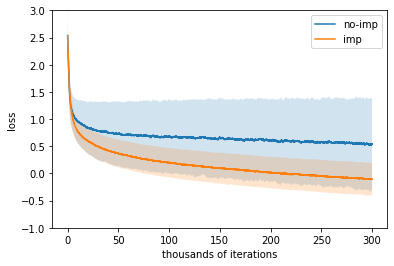

In [12]:
error_ni = std_ni**0.5
error_i = std_i**0.5
x = steps[:int(3e5)]
x = [xx/1000 for xx in x]
plt.plot(x, mu_ni, label='no-imp')
plt.fill_between(x, mu_ni-error_ni, mu_ni+error_ni, alpha=0.2)
plt.plot(x, mu_i, label='imp')
plt.fill_between(x, mu_i-error_i, mu_i+error_i, alpha=0.2)
plt.ylim(-1.,3.)
plt.xlabel('thousands of iterations')
plt.ylabel('loss')
plt.legend()
plt.savefig('./plots/imp.pdf')